# Theme 3：CNN 训练调优 —— 优化器、学习率与正则化策略深度分析

**说明：**  
- 设备：建议在 GPU 环境下跑（Colab、local GPU）。  
- 数据集：CIFAR-10，训练时所有实验共用同一套基础增强（随机裁剪、随机水平翻转、归一化）。  
- 基础模型：  
  1. SimpleCNN（4 层卷积 + BN + Dropout），架构在代码中给出。  
  2. ResNet-18（随机初始化，不加载预训练权重，去掉最初的 maxpool 并改最后全联接输出为 10 类）。  
- 对比维度：  
  1. **优化器**：SGD（带 Momentum + weight_decay） vs. Adam。  
  2. **学习率策略**：StepLR vs. CosineAnnealingLR。  
  3. **正则化**：weight decay (L2) + Dropout vs. 无。  
- 评估指标：训练集/测试集的 Loss、Accuracy；最终 epoch 的 train/val accuracy；FLOPs & 参数量 （可选，用 thop 或 ptflops）。   


In [1]:
## 1. 环境检查 & 导入依赖

# ----------------------------------------------
# 1.1 检查 PyTorch 版本、GPU 状态，导入基本库
# ----------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}, torch version: {torch.__version__}")

Using device: cuda, torch version: 1.10.0+cu111


In [2]:
# ----------------------------------------------
# 2.1 定义训练 & 测试数据的 transforms
# ----------------------------------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# ----------------------------------------------
# 2.2 下载并加载 CIFAR-10
# ----------------------------------------------
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)
print("Train samples:", len(trainset), " Test samples:", len(testset))


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train samples: 50000  Test samples: 10000


In [3]:
# ----------------------------------------------
# 3.1.1 定义 SimpleCNN 类
# ----------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNN, self).__init__()
        # Conv1: 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # Conv2: 64 -> 128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 最大池化
        # Conv3: 128 -> 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # Conv4: 256 -> 256
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        # 最后两层全连接
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.dropout = nn.Dropout(dropout_prob)  # dropout
        self.fc2 = nn.Linear(1024, 10)  # CIFAR-10 共10类

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 尺寸从 32x32 -> 16x16

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # 尺寸从 16x16 -> 8x8

        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 测试一下模型结构
dummy = torch.randn(2, 3, 32, 32)
model = SimpleCNN(dropout_prob=0.5)
print(model)
out = model(dummy)
print("Output shape:", out.shape)  # 应该是 [2, 10]


SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
Output shape: torch.Size([2, 10])


In [4]:
# ----------------------------------------------
# 3.2.1 定义获取随机初始化 ResNet-18 的函数
# ----------------------------------------------
def get_resnet18_model():
    model = resnet18(pretrained=False)  # 完全随机初始化
    # 把第一层 7x7 大卷积改成 3x3，stride=1，padding=1，去掉 MaxPool
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # 直接跳过最初的 MaxPool
    # 替换最后的 fc: 512 -> 10
    model.fc = nn.Linear(512, 10)
    return model

# 测试一下 ResNet-18 结构
res_model = get_resnet18_model()
print(res_model)
o = res_model(dummy)  # [2,10]
print("ResNet-18 Output shape:", o.shape)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [5]:
# ----------------------------------------------
# 4.1 定义单 epoch 的训练
# ----------------------------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ----------------------------------------------
# 4.2 定义验证/测试函数
# ----------------------------------------------
def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    epoch_loss = val_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ----------------------------------------------
# 4.3 定义完整的训练 + 验证流程
# ----------------------------------------------
def train_and_evaluate(model, optimizer, scheduler, 
                       num_epochs, trainloader, testloader, criterion, device):
    model = model.to(device)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # ----- 训练 -----
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
        scheduler.step()  # 如果是 epoch 结束之后再更新学习率

        # ----- 验证 -----
        val_loss, val_acc = evaluate(model, testloader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%  |  "
              f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.2f}%  |  LR: {optimizer.param_groups[0]['lr']:.5f}")

    return model, history


In [6]:
num_epochs = 30   
batch_size = 128
lr_sgd = 0.1
lr_adam = 0.001
momentum = 0.9
weight_decay = 5e-4    # L2 正则

# 重新构造 dataloader（如果需要修改 batch_size）
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()


In [7]:
# ----------------------------------------------
# 5.2.1.1 初始化模型
# ----------------------------------------------
model_cnn_sgd = SimpleCNN(dropout_prob=0.5).to(device)

# ----------------------------------------------
# 5.2.1.2 定义优化器 & 学习率调度
# ----------------------------------------------
optimizer_cnn_sgd = optim.SGD(model_cnn_sgd.parameters(), 
                              lr=lr_sgd, momentum=momentum, weight_decay=weight_decay)
scheduler_cnn_sgd = optim.lr_scheduler.StepLR(optimizer_cnn_sgd, step_size=5, gamma=0.1)

# ----------------------------------------------
# 5.2.1.3 训练 & 验证
# ----------------------------------------------
print("\n>>> SimpleCNN (Dropout=0.5, weight_decay=5e-4) | Optimizer: SGD | Schedule: StepLR")
start_time = time.time()
model_cnn_sgd, hist_cnn_sgd = train_and_evaluate(
    model_cnn_sgd, optimizer_cnn_sgd, scheduler_cnn_sgd,
    num_epochs, trainloader, testloader, criterion, device
)
print("Time elapsed: {:.2f} min\n".format((time.time() - start_time)/60))



>>> SimpleCNN (Dropout=0.5, weight_decay=5e-4) | Optimizer: SGD | Schedule: StepLR
Epoch [1/30]  Train Loss: 2.7044  Train Acc: 22.97%  |  Val Loss: 1.7649  Val Acc: 34.86%  |  LR: 0.10000
Epoch [2/30]  Train Loss: 1.7937  Train Acc: 33.43%  |  Val Loss: 1.5356  Val Acc: 43.59%  |  LR: 0.10000
Epoch [3/30]  Train Loss: 1.6663  Train Acc: 38.48%  |  Val Loss: 1.4739  Val Acc: 46.16%  |  LR: 0.10000
Epoch [4/30]  Train Loss: 1.5598  Train Acc: 42.75%  |  Val Loss: 1.3965  Val Acc: 47.89%  |  LR: 0.10000
Epoch [5/30]  Train Loss: 1.4650  Train Acc: 46.55%  |  Val Loss: 1.4209  Val Acc: 49.25%  |  LR: 0.01000
Epoch [6/30]  Train Loss: 1.2630  Train Acc: 54.31%  |  Val Loss: 1.1057  Val Acc: 60.76%  |  LR: 0.01000
Epoch [7/30]  Train Loss: 1.1966  Train Acc: 56.94%  |  Val Loss: 1.0615  Val Acc: 62.17%  |  LR: 0.01000
Epoch [8/30]  Train Loss: 1.1638  Train Acc: 58.14%  |  Val Loss: 1.0481  Val Acc: 62.38%  |  LR: 0.01000
Epoch [9/30]  Train Loss: 1.1346  Train Acc: 59.54%  |  Val Loss: 1.

In [8]:
# ----------------------------------------------
# 5.2.2.1 初始化模型
# ----------------------------------------------
model_cnn_adam = SimpleCNN(dropout_prob=0.5).to(device)

# ----------------------------------------------
# 5.2.2.2 定义优化器 & 学习率调度
# ----------------------------------------------
optimizer_cnn_adam = optim.Adam(model_cnn_adam.parameters(), 
                                lr=lr_adam, weight_decay=weight_decay)
scheduler_cnn_adam = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_adam, T_max=num_epochs)

# ----------------------------------------------
# 5.2.2.3 训练 & 验证
# ----------------------------------------------
print("\n>>> SimpleCNN (Dropout=0.5, weight_decay=5e-4) | Optimizer: Adam | Schedule: CosineAnnealing")
start_time = time.time()
model_cnn_adam, hist_cnn_adam = train_and_evaluate(
    model_cnn_adam, optimizer_cnn_adam, scheduler_cnn_adam,
    num_epochs, trainloader, testloader, criterion, device
)
print("Time elapsed: {:.2f} min\n".format((time.time() - start_time)/60))



>>> SimpleCNN (Dropout=0.5, weight_decay=5e-4) | Optimizer: Adam | Schedule: CosineAnnealing
Epoch [1/30]  Train Loss: 2.0629  Train Acc: 31.20%  |  Val Loss: 1.5867  Val Acc: 40.71%  |  LR: 0.00100
Epoch [2/30]  Train Loss: 1.5227  Train Acc: 43.57%  |  Val Loss: 1.3329  Val Acc: 50.96%  |  LR: 0.00099
Epoch [3/30]  Train Loss: 1.3401  Train Acc: 51.34%  |  Val Loss: 1.0440  Val Acc: 62.08%  |  LR: 0.00098
Epoch [4/30]  Train Loss: 1.2110  Train Acc: 56.62%  |  Val Loss: 0.9918  Val Acc: 65.09%  |  LR: 0.00096
Epoch [5/30]  Train Loss: 1.1008  Train Acc: 60.73%  |  Val Loss: 0.9285  Val Acc: 67.20%  |  LR: 0.00093
Epoch [6/30]  Train Loss: 1.0252  Train Acc: 63.86%  |  Val Loss: 0.9542  Val Acc: 66.17%  |  LR: 0.00090
Epoch [7/30]  Train Loss: 0.9605  Train Acc: 66.38%  |  Val Loss: 0.7965  Val Acc: 72.10%  |  LR: 0.00087
Epoch [8/30]  Train Loss: 0.9163  Train Acc: 68.26%  |  Val Loss: 0.9104  Val Acc: 68.84%  |  LR: 0.00083
Epoch [9/30]  Train Loss: 0.8519  Train Acc: 70.69%  |  Va

In [9]:
# ----------------------------------------------
# 5.3.1.1 初始化模型 (随机 init)
# ----------------------------------------------
model_res_sgd = get_resnet18_model().to(device)

# ----------------------------------------------
# 5.3.1.2 定义优化器 & 学习率调度
# ----------------------------------------------
optimizer_res_sgd = optim.SGD(model_res_sgd.parameters(), 
                              lr=lr_sgd, momentum=momentum, weight_decay=weight_decay)
scheduler_res_sgd = optim.lr_scheduler.StepLR(optimizer_res_sgd, step_size=5, gamma=0.1)

# ----------------------------------------------
# 5.3.1.3 训练 & 验证
# ----------------------------------------------
print("\n>>> ResNet-18 (weight_decay=5e-4) | Optimizer: SGD | Schedule: StepLR")
start_time = time.time()
model_res_sgd, hist_res_sgd = train_and_evaluate(
    model_res_sgd, optimizer_res_sgd, scheduler_res_sgd,
    num_epochs, trainloader, testloader, criterion, device
)
print("Time elapsed: {:.2f} min\n".format((time.time() - start_time)/60))



>>> ResNet-18 (weight_decay=5e-4) | Optimizer: SGD | Schedule: StepLR
Epoch [1/30]  Train Loss: 1.9183  Train Acc: 31.06%  |  Val Loss: 1.6072  Val Acc: 38.93%  |  LR: 0.10000
Epoch [2/30]  Train Loss: 1.4061  Train Acc: 48.48%  |  Val Loss: 1.4389  Val Acc: 48.18%  |  LR: 0.10000
Epoch [3/30]  Train Loss: 1.1544  Train Acc: 58.58%  |  Val Loss: 1.1408  Val Acc: 60.27%  |  LR: 0.10000
Epoch [4/30]  Train Loss: 0.9701  Train Acc: 65.63%  |  Val Loss: 0.9444  Val Acc: 66.99%  |  LR: 0.10000
Epoch [5/30]  Train Loss: 0.8237  Train Acc: 71.16%  |  Val Loss: 0.9256  Val Acc: 67.38%  |  LR: 0.01000
Epoch [6/30]  Train Loss: 0.5726  Train Acc: 80.14%  |  Val Loss: 0.5460  Val Acc: 80.67%  |  LR: 0.01000
Epoch [7/30]  Train Loss: 0.5080  Train Acc: 82.22%  |  Val Loss: 0.5149  Val Acc: 82.36%  |  LR: 0.01000
Epoch [8/30]  Train Loss: 0.4721  Train Acc: 83.55%  |  Val Loss: 0.4868  Val Acc: 83.09%  |  LR: 0.01000
Epoch [9/30]  Train Loss: 0.4410  Train Acc: 84.54%  |  Val Loss: 0.4758  Val Acc

In [10]:
# ----------------------------------------------
# 5.3.2.1 初始化模型 (随机 init)
# ----------------------------------------------
model_res_adam = get_resnet18_model().to(device)

# ----------------------------------------------
# 5.3.2.2 定义优化器 & 学习率调度
# ----------------------------------------------
optimizer_res_adam = optim.Adam(model_res_adam.parameters(), 
                                lr=lr_adam, weight_decay=weight_decay)
scheduler_res_adam = optim.lr_scheduler.CosineAnnealingLR(optimizer_res_adam, T_max=num_epochs)

# ----------------------------------------------
# 5.3.2.3 训练 & 验证
# ----------------------------------------------
print("\n>>> ResNet-18 (weight_decay=5e-4) | Optimizer: Adam | Schedule: CosineAnnealing")
start_time = time.time()
model_res_adam, hist_res_adam = train_and_evaluate(
    model_res_adam, optimizer_res_adam, scheduler_res_adam,
    num_epochs, trainloader, testloader, criterion, device
)
print("Time elapsed: {:.2f} min\n".format((time.time() - start_time)/60))



>>> ResNet-18 (weight_decay=5e-4) | Optimizer: Adam | Schedule: CosineAnnealing
Epoch [1/30]  Train Loss: 1.3663  Train Acc: 50.02%  |  Val Loss: 1.2607  Val Acc: 55.57%  |  LR: 0.00100
Epoch [2/30]  Train Loss: 0.9514  Train Acc: 66.36%  |  Val Loss: 0.9507  Val Acc: 67.49%  |  LR: 0.00099
Epoch [3/30]  Train Loss: 0.7732  Train Acc: 73.14%  |  Val Loss: 1.1048  Val Acc: 65.41%  |  LR: 0.00098
Epoch [4/30]  Train Loss: 0.6807  Train Acc: 76.42%  |  Val Loss: 0.7070  Val Acc: 76.42%  |  LR: 0.00096
Epoch [5/30]  Train Loss: 0.6075  Train Acc: 79.04%  |  Val Loss: 0.6632  Val Acc: 78.30%  |  LR: 0.00093
Epoch [6/30]  Train Loss: 0.5442  Train Acc: 81.70%  |  Val Loss: 0.8579  Val Acc: 71.84%  |  LR: 0.00090
Epoch [7/30]  Train Loss: 0.5064  Train Acc: 82.74%  |  Val Loss: 0.7457  Val Acc: 74.93%  |  LR: 0.00087
Epoch [8/30]  Train Loss: 0.4646  Train Acc: 84.20%  |  Val Loss: 0.7540  Val Acc: 75.25%  |  LR: 0.00083
Epoch [9/30]  Train Loss: 0.4394  Train Acc: 85.08%  |  Val Loss: 0.588

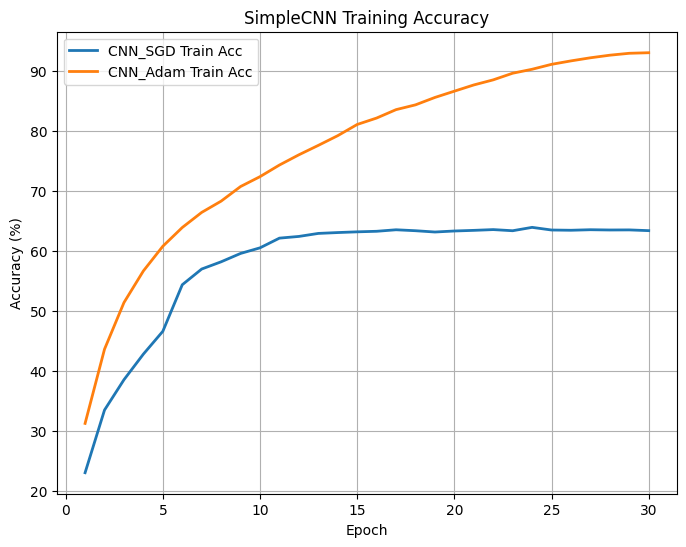

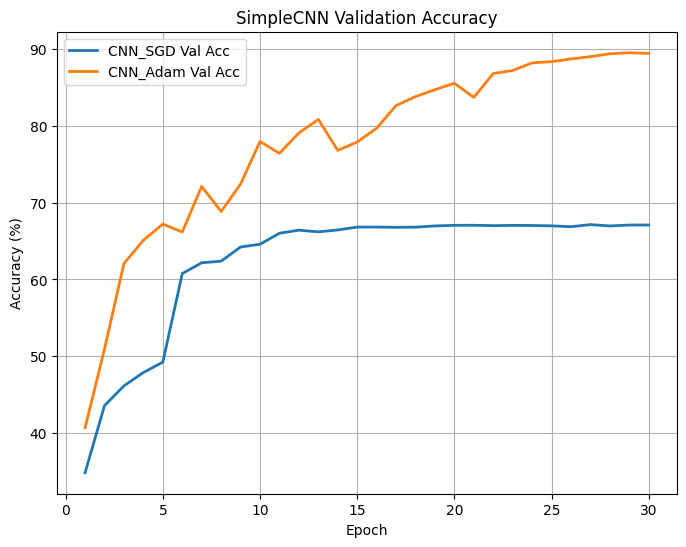

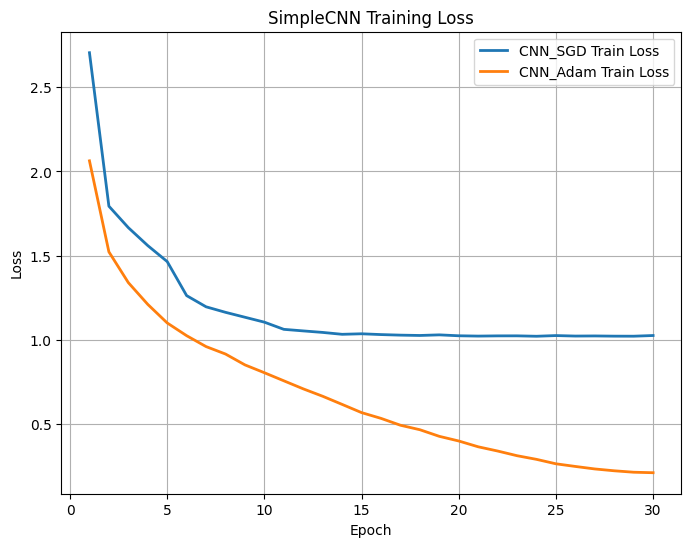

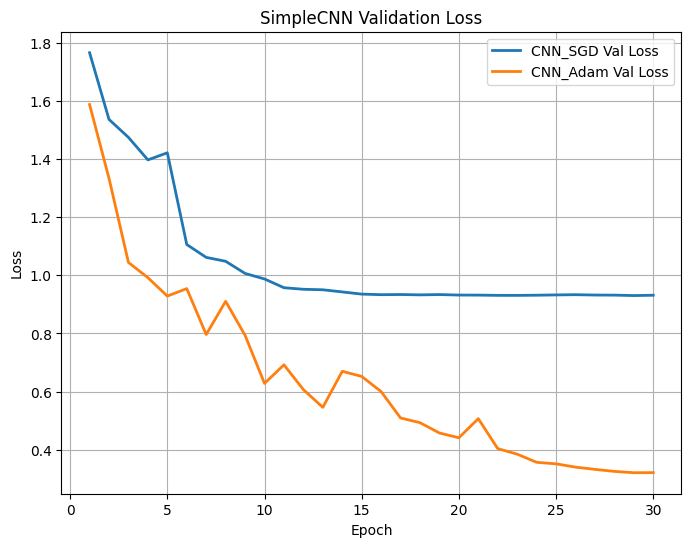

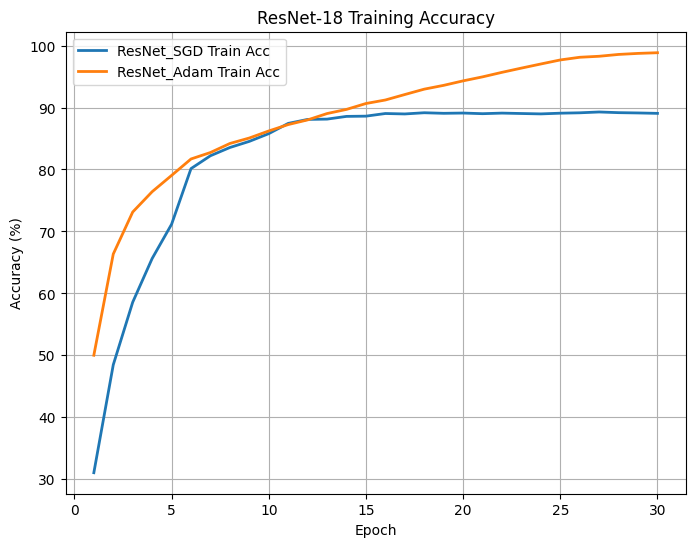

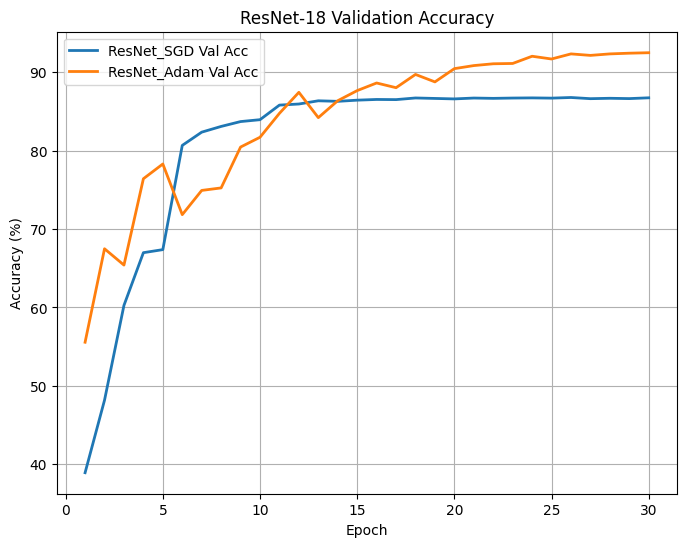

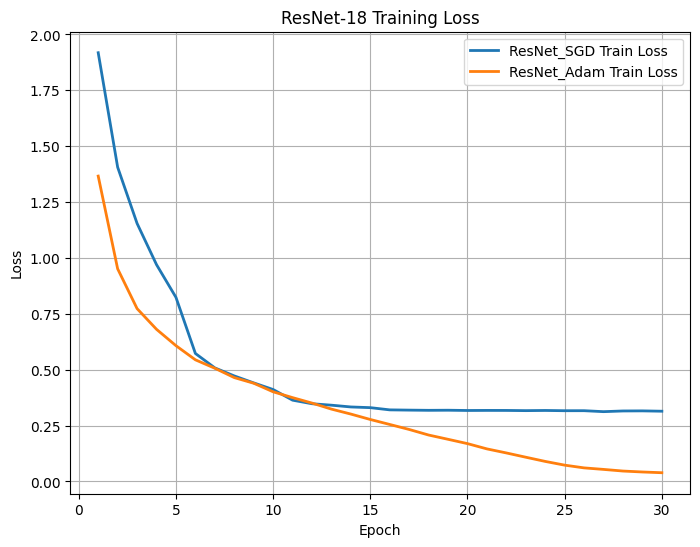

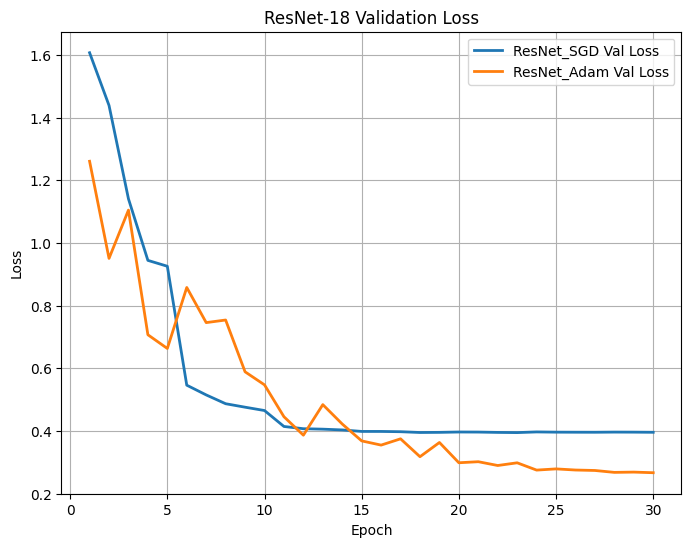

In [11]:
# ----------------------------------------------
# 6.1 定义绘图函数：画多个曲线
# ----------------------------------------------
def plot_curves(histories, labels, title, ylabel):
    epochs = np.arange(1, len(histories[0]) + 1)
    plt.figure(figsize=(8,6))
    for hist, label in zip(histories, labels):
        plt.plot(epochs, hist, label=label, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------------------------
# 6.2 SimpleCNN Accuracy & Loss 对比
# ----------------------------------------------
# 6.2.1 训练 Accuracy
plot_curves(
    [hist_cnn_sgd['train_acc'], hist_cnn_adam['train_acc']],
    ['CNN_SGD Train Acc', 'CNN_Adam Train Acc'],
    'SimpleCNN Training Accuracy',
    'Accuracy (%)'
)

# 6.2.2 验证 Accuracy
plot_curves(
    [hist_cnn_sgd['val_acc'], hist_cnn_adam['val_acc']],
    ['CNN_SGD Val Acc', 'CNN_Adam Val Acc'],
    'SimpleCNN Validation Accuracy',
    'Accuracy (%)'
)

# 6.2.3 训练 Loss
plot_curves(
    [hist_cnn_sgd['train_loss'], hist_cnn_adam['train_loss']],
    ['CNN_SGD Train Loss', 'CNN_Adam Train Loss'],
    'SimpleCNN Training Loss',
    'Loss'
)

# 6.2.4 验证 Loss
plot_curves(
    [hist_cnn_sgd['val_loss'], hist_cnn_adam['val_loss']],
    ['CNN_SGD Val Loss', 'CNN_Adam Val Loss'],
    'SimpleCNN Validation Loss',
    'Loss'
)

# ----------------------------------------------
# 6.3 ResNet-18 Accuracy & Loss 对比
# ----------------------------------------------
# 6.3.1 训练 Accuracy
plot_curves(
    [hist_res_sgd['train_acc'], hist_res_adam['train_acc']],
    ['ResNet_SGD Train Acc', 'ResNet_Adam Train Acc'],
    'ResNet-18 Training Accuracy',
    'Accuracy (%)'
)

# 6.3.2 验证 Accuracy
plot_curves(
    [hist_res_sgd['val_acc'], hist_res_adam['val_acc']],
    ['ResNet_SGD Val Acc', 'ResNet_Adam Val Acc'],
    'ResNet-18 Validation Accuracy',
    'Accuracy (%)'
)

# 6.3.3 训练 Loss
plot_curves(
    [hist_res_sgd['train_loss'], hist_res_adam['train_loss']],
    ['ResNet_SGD Train Loss', 'ResNet_Adam Train Loss'],
    'ResNet-18 Training Loss',
    'Loss'
)

# 6.3.4 验证 Loss
plot_curves(
    [hist_res_sgd['val_loss'], hist_res_adam['val_loss']],
    ['ResNet_SGD Val Loss', 'ResNet_Adam Val Loss'],
    'ResNet-18 Validation Loss',
    'Loss'
)


In [12]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['SimpleCNN', 'SimpleCNN', 'ResNet-18', 'ResNet-18'],
    'Optimizer+Schedule': ['SGD+StepLR', 'Adam+Cosine', 'SGD+StepLR', 'Adam+Cosine'],
    'Final Train Acc (%)': [
        hist_cnn_sgd['train_acc'][-1],
        hist_cnn_adam['train_acc'][-1],
        hist_res_sgd['train_acc'][-1],
        hist_res_adam['train_acc'][-1]
    ],
    'Final Val Acc (%)': [
        hist_cnn_sgd['val_acc'][-1],
        hist_cnn_adam['val_acc'][-1],
        hist_res_sgd['val_acc'][-1],
        hist_res_adam['val_acc'][-1]
    ]
})

# 如果要算模型参数量 & FLOPs，可参考下面（需先 pip install thop）：
# from thop import profile
# dummy_input = torch.randn(1, 3, 32, 32).to(device)
# macs_cnn, params_cnn = profile(SimpleCNN(), inputs=(dummy_input,))
# macs_res, params_res = profile(get_resnet18_model().to(device), inputs=(dummy_input,))
# results['Params'] = [params_cnn, params_cnn, params_res, params_res]
# results['FLOPs'] = [macs_cnn, macs_cnn, macs_res, macs_res]

print(results)


       Model Optimizer+Schedule  Final Train Acc (%)  Final Val Acc (%)
0  SimpleCNN         SGD+StepLR               63.336              67.08
1  SimpleCNN        Adam+Cosine               93.004              89.40
2  ResNet-18         SGD+StepLR               89.060              86.74
3  ResNet-18        Adam+Cosine               98.848              92.49
